# Uso del módulo fordward MoM comparado con FDTD

En el módulo *forward* se implementan algunas formas de resolución del problema directo de imágenes por microondas de un arreglo circular de antenas. En este apartado comparamos la solución del Método de los Momentos con la analítica comentada en el apartado anterior.

Se deben cumplir algunas dependencias, Meep debe estar instalado para usar el método FDTD (https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/)).

Libros y publicaciones:

[1] Xudong Chen, Computational Methods for Electromagnetic Inverse Scattering

[2] Matteo Pastorino, Microwave Imaging


Módulo Python: forward

Autores: Ramiro Irastorza 

Email: rirastorza@iflysib.unlp.edu.ar

### Para correr en Google Colab


Ejecutar este documento en forma dinámica:[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rirastorza/Intro2MI/blob/master/problema_directo/ejemplo_MoM_FDTD.ipynb)

In [ ]:
# install conda
!pip install -q condacolab
import condacolab
condacolab.install()
!which conda

# install meep (python)
!conda install -c conda-forge pymeep

## Parallel Meep (MPI version)
!conda create -n pmp -c conda-forge pymeep=*=mpi_mpich_*
!conda activate pmp

# Install Additional Packages just in case
!pip install nlopt

Para montar la función forward desde github

In [ ]:
!wget https://raw.githubusercontent.com/rirastorza/Intro2MI/blob/main/problema_directo/forward.py


## Ejemplo de uso para validación con modelo teórico analítico

Primero, se cargan los paquetes necesarios.

In [1]:
from forward import *
import numpy as np

/home/ramiro/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Luego las propiedades del cilindro dispersor, los transmisores, los receptores y algunas cosas más.

In [2]:
Tx_mom = 10#Fuente emisora
size_DOI = 2 # size of DOI
f =  0.4e9 #Frecuencia en Hz
#caja de simulacion en [m]
sx = 14#15
sy = 14#15
box = [sx,sy]
a = 0.1#0.1 #meep unit
#Antenas---------------------------------------------------------------
nant_f = 16 #antenas emisoras
rant_f = 6 #radio de antenas fuentes [m]
nant_r = 16 #antenas receptoras
rant_r =3#3 #radio de antenas receptoras[m]
tx = Tx_mom # Fuente analizada
#Medio acoplante---------------------------------------------------------------
epsc = 1 #Vacío
# Medio dispersor (cilindro)---------------------------------------------------
r = 0.5 #10.0e-3/2 #radio del cilindro
Xc = 0.25    #posición del centro en x
Yc = 0   #posición del centro en y
epsr = 1.8
resolucion = 5 #resolución FDTD

Se crean los objetos según las definiciones de la librería *forward*.

In [3]:
TRANSMISOR_parameters = TRANSMISOR_parameters()
ACOPLANTE_parameters = ACOPLANTE_parameters()
cilindro = SCATTERER_parameters()
#Antenas-----------------------------------------------------------------------
TRANSMISOR_parameters.f = f #frecuencia 1 GHz (por defecto)
TRANSMISOR_parameters.amp =3750#3500 #Amplitud de la fuente
TRANSMISOR_parameters.rhoS = rant_f #radio de transmisores
TRANSMISOR_parameters.S = nant_f ##cantidad de transmisores (fuentes)
#Coordenadas antenas fuentes
angulo_f = N.linspace(0.0, 2.0*pi, nant_f+1)
xantenas_f = (TRANSMISOR_parameters.rhoS)*N.cos(angulo_f)
yantenas_f = (TRANSMISOR_parameters.rhoS)*N.sin(angulo_f)
RECEPTOR_parameters.f = f #frecuencia 1 GHz (por defecto)
RECEPTOR_parameters.amp =3750#3500 #Amplitud de la fuente
RECEPTOR_parameters.rhoS = rant_r #radio de transmisores
RECEPTOR_parameters.S = nant_r ##cantidad de transmisores (fuentes)
#Coordenadas antenas receptoras
angulo_r = N.linspace(0.0, 2.0*pi, nant_r+1)
xantenas_r= (RECEPTOR_parameters.rhoS)*N.cos(angulo_r)
yantenas_r = (RECEPTOR_parameters.rhoS)*N.sin(angulo_r)
#Medio acoplante---------------------------------------------------------------
ACOPLANTE_parameters.f = TRANSMISOR_parameters.f
ACOPLANTE_parameters.epsr = epsc.real
ACOPLANTE_parameters.sigma = -epsc.imag*(eps0*2*pi*TRANSMISOR_parameters.f)
# Medio dispersor (cilindro)---------------------------------------------------
cilindro.epsr = epsr #permitividad relativa.
cilindro.sigma = 0.0
cilindro.f = TRANSMISOR_parameters.f #frecuencia 1 GHz (por defecto).
cilindro.radio = r
cilindro.xc = Xc
cilindro.yc = Yc

Se puede dibujar la geometría.

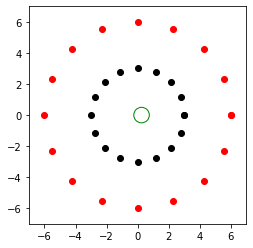

In [4]:
nxantenas_r=np.round(xantenas_r*resolucion/a)+sx/a*resolucion/2
nyantenas_r=np.round(yantenas_r*resolucion/a)+sx/a*resolucion/2
fig1 = plt.figure(1)
f1 = fig1.add_subplot(111)
cilindro1 = plt.Circle((Xc,Yc),r, color='g',fill = False) #Dibujo la geometría generada
plt.xlim(-sx/2, sx/2)
plt.ylim(-sy/2, sy/2)
f1.add_artist(cilindro1)
f1.plot(xantenas_r,yantenas_r,'ok')
f1.plot(xantenas_f,yantenas_f,'or')
f1.set_aspect('equal')

Ahora se llama a las dos funciones *RunMoM* (resuelve el método de los Momentos según *Richmond 1968*) y *RunMeep* (utilizando FDTD con el programa Meep, https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/)

In [5]:
Et_forw, epsono_r = RunMoM(cilindro,ACOPLANTE_parameters,TRANSMISOR_parameters,RECEPTOR_parameters,size_doi = size_DOI,Tx = Tx_mom ,RES = 40)

Ezfdtd,eps_data = RunMeep(cilindro,ACOPLANTE_parameters,TRANSMISOR_parameters, tx, box,RES = resolucion,calibration = False, unit = a,nt = 300)


sxa:  140.0 sxa:  140.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.000630856 s
Working in 2D dimensions.
Computational cell is 140 x 140 x 0 with resolution 5
     cylinder, center = (0,2.5,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1.8,1.8,1.8)
time for set_epsilon = 0.324037 s
-----------
Meep: using complex fields.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Meep progress: 54.7/300.0 = 18.2% done in 4.0s, 18.0s to go
on time step 548 (time=54.8), 0.00731238 s/step
Meep progress: 110.80000000000001/300.0 = 36.9% done in 8.0s, 13.7s to go
on time step 1109 (time=110.9), 0.00713275 s/step
Meep progress: 166.9/300.0 = 55.6% done in 12.0s, 9.6s to go
on time step 1670 (time=167), 0.00713271 s/step
Meep progress: 222.9/300.0 = 74.3% done in 16.0s, 5.5s to go
on time step 2230 (time=223), 0.00714572 s/step
Meep progress: 278.6/300.0 = 92.9% done in 20.0s, 1.5s to go
on time step 2787 (time=278.7), 0.00718511 s/step
run 0 finished at t = 300.0 (3000 timesteps)


Ahora se puede graficar los dos casos.

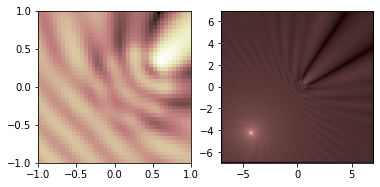

In [6]:
fig2 = plt.figure(2)
f2 = fig2.add_subplot(121)
extent2=[-1,1,-1,1]
f2.imshow(abs(Et_forw),cmap ='pink',origin='lower',extent = extent2)#cmap = 'binary')

f2b = fig2.add_subplot(122)
extent2=[-7,7,-7,7]
f2b.imshow(abs(Ezfdtd),cmap ='pink',origin='lower',extent = extent2)#cmap = 'binary')


Para ver los valores en x = 0, por ejemplo.

/tmp/ipykernel_10357/2467028572.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  f3.legend()


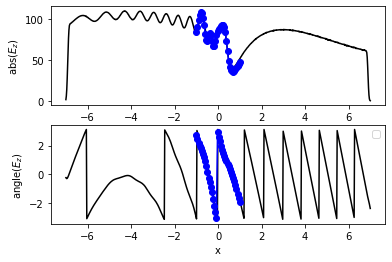

In [7]:
ty_mom2 = np.linspace(-1,1,num=len(Et_forw),endpoint = True)
tyfdtd = np.linspace(-7,7,num=len(Ezfdtd),endpoint = True)

fig3 = plt.figure(6)
f3 = fig3.add_subplot(211)
f3.plot(tyfdtd,np.abs(Ezfdtd[:,int(len(Ezfdtd)/2)]),'-k',label='FDTD')
f3.plot(ty_mom2,np.abs(Et_forw[:,int(len(Et_forw)/2)]),'o-b',label='MoM')
f3.set_xlabel('x')
f3.set_ylabel(r'abs($E_{z}$)')
f3 = fig3.add_subplot(212)
f3.plot(tyfdtd,-np.angle(Ezfdtd[:,int(len(Ezfdtd)/2)]),'-k',)
f3.plot(ty_mom2,np.angle(Et_forw[:,int(len(Et_forw)/2)]),'o-b')
f3.set_xlabel('x')
f3.set_ylabel(r'angle($E_{z}$)')
f3.legend()